## 2.1 Analysis of Symptom Co-occurrence Patterns 
### Objective:
#### The goal of this task is to analyse the co-occurrence patterns of different symptoms within disease profiles. Specifically, the task aims to identify combinations of symptoms that frequently appear together in the same disease. 

### Methods:
#### Implement the Apriori algorithm to analyse the Disease Symptom dataset, identifying common combinations of symptoms that frequently co-occur within the same disease profile. 

In [99]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder

In [100]:
# load dataset
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


#### There are 4920 rows and 18 column (1 `Disease` column and 17 `Symptom` columns). All columns are of 'String' data type.

In [101]:
# Display sample dataset
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# Drop 'Disease' column 
symptom_cols = df.columns.drop('Disease')

# Clean up 'Symptom' columns
df[symptom_cols] = (
    df[symptom_cols]
    .fillna('') # replace NaN with empty string
    .applymap(lambda s: str(s).strip().lower())  # remove spaces and convert to lowercase
)

# Create a sorted list of all unique symptoms across the dataset
unique_symptoms = sorted(
    # Set to automatically remove duplicate symptoms
    set(df[symptom_cols].values.flatten())
)

print(f"Dataset contain {len(unique_symptoms)} unique symptoms: \n")
for symptom in unique_symptoms:
    print(symptom)


Dataset contain 132 unique symptoms: 


abdominal_pain
abnormal_menstruation
acidity
acute_liver_failure
altered_sensorium
anxiety
back_pain
belly_pain
blackheads
bladder_discomfort
blister
blood_in_sputum
bloody_stool
blurred_and_distorted_vision
breathlessness
brittle_nails
bruising
burning_micturition
chest_pain
chills
cold_hands_and_feets
coma
congestion
constipation
continuous_feel_of_urine
continuous_sneezing
cough
cramps
dark_urine
dehydration
depression
diarrhoea
dischromic _patches
distention_of_abdomen
dizziness
drying_and_tingling_lips
enlarged_thyroid
excessive_hunger
extra_marital_contacts
family_history
fast_heart_rate
fatigue
fluid_overload
foul_smell_of urine
headache
high_fever
hip_joint_pain
history_of_alcohol_consumption
increased_appetite
indigestion
inflammatory_nails
internal_itching
irregular_sugar_level
irritability
irritation_in_anus
itching
joint_pain
knee_pain
lack_of_concentration
lethargy
loss_of_appetite
loss_of_balance
loss_of_smell
malaise
mild_fever
moo

C:\Users\User\AppData\Local\Temp\ipykernel_3944\2286193490.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda s: str(s).strip().lower())  # remove spaces and convert to lowercase


#### We observed 131 unique symptoms in the dataset. However, some symptoms may represent the same meaning (e.g., “fever” vs “pyrexia”). To detect such duplicates, we encoded all the symptoms using a sentence transformer model and computed the cosine similarity between every pair of symptom embeddings. We then displayed the top 20 symptom pairs with the highest similarity scores and manually examined them to determine whether they are synonyms.

In [103]:
from sentence_transformers import SentenceTransformer, util

# Load a semantic embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all symptoms into vectors
embeddings = model.encode(unique_symptoms, convert_to_tensor=True)

# Compute pairwise cosine similarity between all symptom embeddings
cosine_sim = util.pytorch_cos_sim(embeddings, embeddings).numpy()

# Collect all unique pairs with their similarity scores
pairs = []
for i in range(len(unique_symptoms)):
    for j in range(i + 1, len(unique_symptoms)):
        pairs.append((unique_symptoms[i], unique_symptoms[j], cosine_sim[i, j]))

# Convert to DataFrame
df_pairs = pd.DataFrame(pairs, columns=['Symptom_1', 'Symptom_2', 'Similarity'])

# Sort and show top 10
df_pairs = df_pairs.sort_values(by='Similarity', ascending=False)

print("Top 20 semantically similar symptom pairs:\n")
print(df_pairs.head(20).to_string(index=False, formatters={'Similarity': '{:.3f}'.format}))


Top 20 semantically similar symptom pairs:

          Symptom_1                 Symptom_2 Similarity
     hip_joint_pain                joint_pain      0.882
         belly_pain              stomach_pain      0.871
     abdominal_pain              stomach_pain      0.870
     abdominal_pain                belly_pain      0.861
  weakness_in_limbs weakness_of_one_body_side      0.791
   excessive_hunger        increased_appetite      0.780
         joint_pain                 knee_pain      0.772
         high_fever                mild_fever      0.770
             nausea                  vomiting      0.770
         dark_urine              yellow_urine      0.760
 increased_appetite          loss_of_appetite      0.758
    muscle_weakness         weakness_in_limbs      0.750
       skin_peeling                 skin_rash      0.747
        muscle_pain           muscle_weakness      0.735
    redness_of_eyes         yellowing_of_eyes      0.732
    muscle_weakness weakness_of_one_body_sid

In [104]:
# Map symptom synonyms before Apriori
synonym_map = {
    'belly_pain': 'stomach_pain',
    'abdominal_pain': 'stomach_pain',
    'swollen_legs': 'swollen_extremeties'
}

# Apply synonym normalization to all 'Symptom' columns
for col in symptom_cols:
    df[col] = df[col].replace(synonym_map)


In [105]:
unique_diseases = df['Disease'].unique()
print(f"Dataset contain {len(unique_diseases)} unique diseases:\n")

for disease in unique_diseases:
    print(disease)


Dataset contain 41 unique diseases:

Fungal infection
Allergy
GERD
Chronic cholestasis
Drug Reaction
Peptic ulcer diseae
AIDS
Diabetes 
Gastroenteritis
Bronchial Asthma
Hypertension 
Migraine
Cervical spondylosis
Paralysis (brain hemorrhage)
Jaundice
Malaria
Chicken pox
Dengue
Typhoid
hepatitis A
Hepatitis B
Hepatitis C
Hepatitis D
Hepatitis E
Alcoholic hepatitis
Tuberculosis
Common Cold
Pneumonia
Dimorphic hemmorhoids(piles)
Heart attack
Varicose veins
Hypothyroidism
Hyperthyroidism
Hypoglycemia
Osteoarthristis
Arthritis
(vertigo) Paroymsal  Positional Vertigo
Acne
Urinary tract infection
Psoriasis
Impetigo


## Perform Apriori on the entire dataset to find frequent itemsets, laying the groundwork for mining association rules against the entire dataset later on

In [106]:
# Flatten all rows into transactions
all_transactions = []

for _, row in df[symptom_cols].iterrows():
    symptoms = [s for s in row if s != '']  # remove empty strings
    if symptoms:
        all_transactions.append(symptoms)

print(f"Flattened {len(all_transactions)} total transactions")

Flattened 4920 total transactions


In [107]:
# Encode transactions and apply Apriori across the entire dataset
te = TransactionEncoder()
te_ary = te.fit(all_transactions).transform(all_transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

min_support_global = 0.05  # lower than per-disease since dataset is larger

frequent_itemsets_global = apriori(df_encoded, 
                                   min_support=min_support_global, 
                                   use_colnames=True)
frequent_itemsets_global = frequent_itemsets_global.sort_values(by='support', ascending=False)

print(f"Found {len(frequent_itemsets_global)} frequent itemsets across all diseases.")
print(frequent_itemsets_global.head(10))

Found 562 frequent itemsets across all diseases.
      support                  itemsets
9    0.392683                 (fatigue)
27   0.389024                (vomiting)
11   0.276829              (high_fever)
24   0.256098            (stomach_pain)
16   0.234146        (loss_of_appetite)
21   0.232927                  (nausea)
10   0.230488                (headache)
125  0.198780        (vomiting, nausea)
72   0.198780     (high_fever, fatigue)
128  0.198780  (stomach_pain, vomiting)


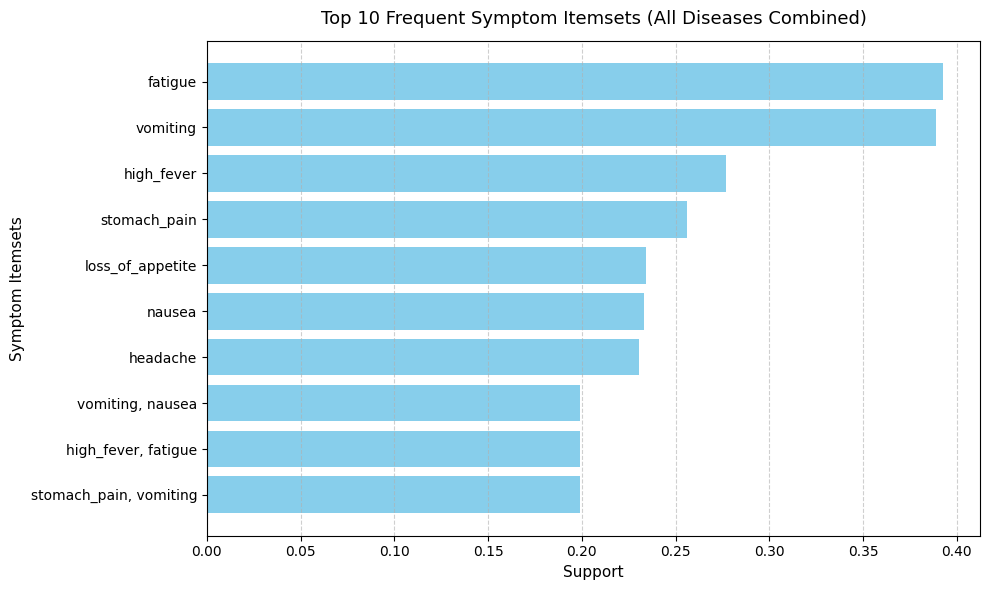

In [108]:
top_n = 10
top_itemsets = frequent_itemsets_global.head(top_n).copy()

# Convert frozensets to readable strings
top_itemsets['itemsets'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_itemsets['itemsets'], top_itemsets['support'], color='skyblue')
plt.gca().invert_yaxis()  # Highest support on top
plt.title('Top 10 Frequent Symptom Itemsets (All Diseases Combined)', fontsize=13, pad=12)
plt.xlabel('Support', fontsize=11)
plt.ylabel('Symptom Itemsets', fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Now we mine Association Rules against the frequent_itemsets_global

In [109]:
# Run association rules on the global frequent itemsets
rules_global = association_rules(frequent_itemsets_global, metric="confidence", min_threshold=0.6)
rules_global = rules_global.sort_values(by='confidence', ascending=False)

In [110]:
# Display top results for global association rules
print("\n=== GLOBAL ASSOCIATION RULES (All Diseases Combined) ===")
display(
    rules_global[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
)


=== GLOBAL ASSOCIATION RULES (All Diseases Combined) ===


,antecedents,consequents,support,confidence,lift
1077,"(fatigue, phlegm, malaise, chills)",(chest_pain),0.062195,1.0,7.068966
3879,"(fatigue, cough, high_fever, phlegm, malaise, ...",(chest_pain),0.054878,1.0,7.068966
1028,"(fatigue, phlegm, cough, malaise)",(chest_pain),0.062195,1.0,7.068966
1102,"(high_fever, phlegm, cough, malaise)",(chest_pain),0.062195,1.0,7.068966
1165,"(fatigue, cough, chills)",(chest_pain),0.062195,1.0,7.068966
...,...,...,...,...,...
3833,"(yellowing_of_eyes, dark_urine)","(vomiting, nausea, loss_of_appetite, joint_pain)",0.054878,0.6,7.343284
4289,"(yellowing_of_eyes, dark_urine)","(yellowish_skin, stomach_pain, vomiting, joint...",0.054878,0.6,10.040816
4383,"(yellowing_of_eyes, dark_urine)","(yellowish_skin, vomiting, loss_of_appetite, j...",0.054878,0.6,10.040816
4244,"(yellowing_of_eyes, dark_urine)","(yellowish_skin, nausea, loss_of_appetite, joi...",0.054878,0.6,10.040816


## Export both frequent itemsets and association rules into excel

In [111]:
frequent_itemsets_global.to_excel("global_frequent_itemsets.xlsx", index=False)
rules_global.to_excel("global_association_rules.xlsx", index=False)